In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('NUS_training_data.csv', encoding= 'unicode_escape', index_col = False)

labels = data['E_OCC']
data['rand'] = pd.Series(np.random.uniform(0,1,len(labels.index)))
data.sort_values(by=['rand'])

,E_OCC_2d,E_OCC,E_OCC_Ttl,E_OCC_Desc,rand
1004,23,231,senior lecturer,teaching. setting and review exam papers. in-c...,0.000057
854,22,222,senior staff nurse,doing a full health assessment on a client. .d...,0.000994
3149,11,111,civil servant,negotiate trade agreements.,0.001080
1274,23,236,special education teacher,teaches persons with special needs such as aut...,0.001304
1406,24,243,marketing specialist,managing the day to day operations of the mark...,0.001373
...,...,...,...,...,...
320,14,141,avp. operations,manage operations for a chain of restaurants. ...,0.998683
1760,26,265,assistant director,controls a film.s artistic and dramatic aspect...,0.999002
203,13,133,site lead/manager,".to manage the site team, which consists of ne...",0.999022
2809,36,361,preschool teacher,teach basic language. calculations and skills....,0.999310


In [2]:
# Function to remove Punctuation

import string

def remove_punc(text):
    text_nopunc = "".join([char for char in text if char not in string.punctuation])  # discard all punctuation
    return text_nopunc

data['desc_clean'] = data['E_OCC_Desc'].apply(lambda x: remove_punc(x))

# data.head()

In [3]:
# Function to Tokenize words

import re

def tokenise(text):
    tokens = re.split('\W+', text)
    return tokens

data['desc_tokenised'] = data['desc_clean'].apply(lambda x: tokenise(x.lower()))

# data.head()

In [4]:
# Function to remove stopwords

import nltk
nltk.download('stopwords')

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(lst):
    text = [word for word in lst if word not in stopword]  # Remove all stopwords
    return text

data['desc_nostop'] = data['desc_tokenised'].apply(lambda x: remove_stopwords(x))

# data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eugene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Lemmatizing

import nltk
nltk.download('wordnet')

wn = nltk.WordNetLemmatizer()

def lemmatizing(token):
    text = [wn.lemmatize(word) for word in token]
    return text

data['desc_lemmatized'] = data['desc_nostop'].apply(lambda x: lemmatizing(x))

# data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eugene\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopword]
    return text

In [7]:
data['desc_lemmatized']

0       [position, support, vice, president, residenti...
1       [agree, develop, project, organization, scope,...
2       [direct, control, company, operation, give, st...
3       [responsibility, include, managing, oversq, ft...
4       [program, director, oversees, coordination, ad...
                              ...                        
3160    [acting, theatre, voicing, tv, commercial, cor...
3161                                     [assist, doctor]
3162                              [perform, stage, event]
3163                                     [assisting, vet]
3164                                      [film, editing]
Name: desc_lemmatized, Length: 3165, dtype: object

In [8]:
# Create a list of the topic numbers we want to try

topic_nums = list(np.arange(1, 68 + 1, 2))

# Bag of Words NMF + Coherence Score

In [9]:
from gensim.corpora import Dictionary

texts = data['desc_lemmatized']
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [10]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.nmf import Nmf

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        normalize=True,
        random_state=1
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

In [11]:
from operator import itemgetter

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

15


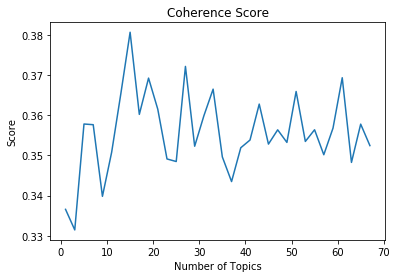

In [12]:
import matplotlib.pyplot as plt

plt.plot(*zip(*scores))
plt.title('Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.show()

# TF-IDF NMF

In [13]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [18]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.nmf import Nmf

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf_tfidf = Nmf(corpus=corpus_tfidf,
                    num_topics=num,
                    id2word=dictionary,
                    minimum_probability=0.01,
                    w_max_iter=300,
                    w_stop_condition=0.0001,
                    h_max_iter=100,
                    h_stop_condition=0.001,
                    normalize=True,
                    random_state=2)
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf_tfidf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

In [19]:
from operator import itemgetter

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

67


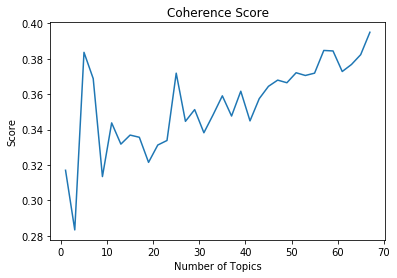

In [20]:
import matplotlib.pyplot as plt

plt.plot(*zip(*scores))
plt.title('Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.show()

In [21]:
nmf_tfidf = Nmf(corpus=corpus_tfidf,
                num_topics=best_num_topics,
                id2word=dictionary,
                minimum_probability=0.01,
                w_max_iter=300,
                w_stop_condition=0.0001,
                h_max_iter=100,
                h_stop_condition=0.001,
                normalize=True,
                random_state=3)

In [22]:
for idx, topic in nmf_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format((idx+1), topic))

Topic: 0 Word: 0.010*"program" + 0.008*"centre" + 0.008*"region" + 0.006*"manage" + 0.006*"marketing" + 0.005*"retail" + 0.005*"asia" + 0.005*"east" + 0.005*"south" + 0.005*"beauty"
Topic: 1 Word: 0.032*"medium" + 0.014*"chinese" + 0.011*"hard" + 0.011*"aspac" + 0.008*"drive" + 0.007*"digital" + 0.007*"research" + 0.007*"content" + 0.007*"social" + 0.006*"job"
Topic: 2 Word: 0.017*"project" + 0.012*"solution" + 0.011*"technical" + 0.011*"sale" + 0.011*"manage" + 0.011*"budget" + 0.010*"product" + 0.008*"expenditure" + 0.008*"information" + 0.006*"technology"
Topic: 3 Word: 0.009*"bible" + 0.008*"property" + 0.007*"help" + 0.007*"stakeholder" + 0.007*"investment" + 0.007*"news" + 0.006*"network" + 0.006*"client" + 0.006*"residential" + 0.005*"epn"
Topic: 4 Word: 0.027*"sale" + 0.010*"support" + 0.009*"customer" + 0.008*"user" + 0.008*"vessel" + 0.007*"software" + 0.007*"technical" + 0.006*"delivery" + 0.006*"rating" + 0.005*"service"
Topic: 5 Word: 0.021*"education" + 0.009*"student" + 